# 18.04.20

**Authors:** Miron Rogovets, Demid Afonichev, Maxim Shmakov

---

### Task 1. Open _dollar.dta_ file

Dependent variable: _dollar_

Independent variable: _time_

- Use quadratic model to describe the change in the dollar exchange rate over the
considered period.
- Describe parameters of the regression model.
- Do the diagnostics of the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
import statsmodels.formula.api as sm
from statsmodels.api import add_constant
import linearmodels.panel as lm

In [2]:
df = pd.read_stata('data/dollar.dta')
print(df.shape)
df.head(3)

(283, 3)


,dollar,date,time
0,32.6587,01.01.2014,1.0
1,33.1547,10.01.2014,2.0
2,33.2062,11.01.2014,3.0


In [3]:
_, meta = pyreadstat.read_dta('data/dollar.dta')
meta.column_names_to_labels

{'dollar': 'dollar exchange rate', 'date': 'date', 'time': None}

In [4]:
df.dtypes

dollar    float64
date       object
time      float64
dtype: object

Check if we have any missing values

In [5]:
df.isna().sum()

dollar    0
date      0
time      0
dtype: int64

Drop unused column

In [6]:
data = df.drop(columns=['date'])
data.head(3)

,dollar,time
0,32.6587,1.0
1,33.1547,2.0
2,33.2062,3.0


Then we create and fit our model

In [7]:
formula_str = 'dollar ~ time + np.power(time, 2)'
formula_str

'dollar ~ time + np.power(time, 2)'

In [8]:
model = sm.ols(formula=formula_str, data=data)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 dollar   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1594.
Date:                Thu, 23 Apr 2020   Prob (F-statistic):          1.00e-153
Time:                        01:29:56   Log-Likelihood:                -713.96
No. Observations:                 283   AIC:                             1434.
Df Residuals:                     280   BIC:                             1445.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            38.9605      0.54

### Model description

In [9]:
fitted.params

Intercept            38.960516
time                 -0.148388
np.power(time, 2)     0.000896
dtype: float64

We have the following regression equation:

In [10]:
print('Y = {:.3f} + {:.3f}*time + {:.4f}*time^2'.format(fitted.params[0], fitted.params[1], fitted.params[2]))

Y = 38.961 + -0.148*time + 0.0009*time^2


$R^2$ & model significance:

In [11]:
print('R^2 = {:f}'.format(fitted.rsquared))
print('F stat = {:f}'.format(fitted.f_pvalue))

R^2 = 0.919248
F stat = 0.000000


The regression model is statistically significant. It explains 91.9% of dollar’s exchange rate variation

In [12]:
def yes_no(b):
    if abs(b) < 0.05:
        return 'Yes'
    else:
        return 'No'

In [13]:
for i, p in zip(fitted.pvalues[1:].index, fitted.pvalues[1:]):
    print('{} : p-value: {:.3f}, statistically significant? {}'.format(i, p, yes_no(p)))

time : p-value: 0.000, statistically significant? Yes
np.power(time, 2) : p-value: 0.000, statistically significant? Yes


Variables are statistically significant.

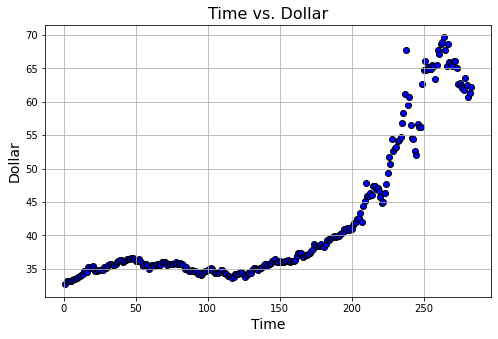

In [14]:
plt.figure(figsize=(8,5))
plt.title('Time vs. Dollar', fontsize=16)
plt.scatter(x=data.time, y=data.dollar, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Dollar', fontsize=14)
plt.show()

We can see that increase in time leads to increase in dollar's exchange rate

To do the diagnostics of the model, we plot the residuals:

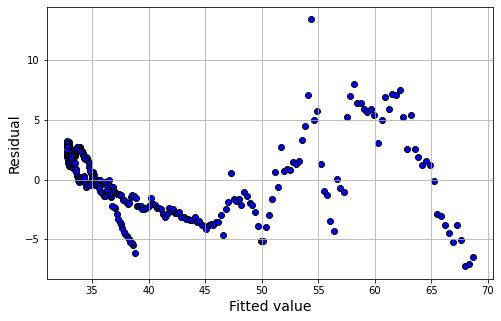

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(x=fitted.fittedvalues, y=fitted.resid, color='blue', edgecolor='k')
plt.grid(True)
plt.xlabel('Fitted value', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.show()

We can see a heteroscedasticity from the plot above – there is a relationship between residuals and the fitted values.

---

### Task 2. Open _datafile.dta_ file

There is data from 2007 to 2016 on 96 federal executive bodies. The task is to identify the
relationship between the level of remuneration of civil servants and various factors.

Dependent variable: _Average monthly salary (salary)_

Independent Variables:
- Number of civil servants (v1)
- Number of vacant positions (v2)
- Number of civil servants with higher education (v3)
- Number of civil servants with 2 or more higher education (v4)
- The number of civil servants who received an additional education (v5)
- Number of male civil servants (v6)
- Number of female civil servants (v7)
- Number of civil servants of retirement age (v8)
- The number of civil servants whose work experience is less than 10 years (v9)
- The number of civil servants whose work experience is from 10 to 25 years (v10)
- The number of civil servants whose work experience is 25 years or more (v11)


1. Select at least 7 independent variables (you can select more or all).
2. Conduct tests to select one of three models:
    - pulled regression model
    - a model with fixed effects
    - and a model with random effects.
    Choose the right model and justify your choice
3. Describe the resulting model as a whole.
4. Describe the relationships between the dependent variable and the predictors (which relationships are significant, which are direct, which are inverse). Draw conclusions from the analysis.
5. Save the individual effects as a separate variable and indicate the names of the federal executive bodies with the greatest and least individual effect.

In [16]:
df = pd.read_stata('data/datafile.dta')
print(df.shape)
df.head(3)

(960, 16)


,id,name,year,t,salary,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11
0,4,МИД России,2016,10,147239,3233,93.131687,2812,163,1966,1908,1345,454,1296,1442,515
1,4,МИД России,2012,6,60376,3128,147.392670,0,0,1356,0,0,0,0,0,0
2,4,МИД России,2011,5,59501,3144,134.415016,0,0,1407,0,0,0,0,0,0


In [17]:
_, meta = pyreadstat.read_dta('data/datafile.dta')
meta.column_names_to_labels

{'id': 'id',
 'name': 'Name of the Federal Executive Body',
 'year': 'year',
 't': 'year',
 'salary': 'The average monthly salary of a public servant',
 'v1': 'Number of public servants',
 'v2': 'Number of Vacancies',
 'v3': 'Number of public servants with higher education',
 'v4': 'Number of public servants with two or more higher education diplomas',
 'v5': 'Number of public servants who passed special training',
 'v6': 'Number of public servants who are males',
 'v7': 'Number of public servants who are females',
 'v8': 'Number of public servants who are who are at retirement age',
 'v9': 'Number of public servants with woking experience less than 10 years',
 'v10': 'Number of public servants with woking experience from 10 to 25 years',
 'v11': 'Number of public servants with woking experience more than 25 years'}

In [18]:
data = df.drop(columns=['name', 't'])

Check if we have any missing values

In [19]:
data.isna().sum()

id        0
year      0
salary    0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
dtype: int64

Transform data to panel

In [20]:
data = data.set_index(['id', 'year'])
data.head(3)

salary    v1          v2    v3   v4    v5    v6    v7   v8    v9  \
id year                                                                     
4  2016  147239  3233   93.131687  2812  163  1966  1908  1345  454  1296   
   2012   60376  3128  147.392670     0    0  1356     0     0    0     0   
   2011   59501  3144  134.415016     0    0  1407     0     0    0     0   

          v10  v11  
id year             
4  2016  1442  515  
   2012     0    0  
   2011     0    0

**Pooled regression** model:

In [21]:
exog = add_constant(data[data.columns.drop('salary')])
pool_model = lm.PooledOLS(data.salary, exog)
pool_fitted = pool_model.fit()
print(pool_fitted)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 salary   R-squared:                        0.3112
Estimator:                  PooledOLS   R-squared (Between):              0.4209
No. Observations:                 960   R-squared (Within):               0.2092
Date:                Thu, Apr 23 2020   R-squared (Overall):              0.3112
Time:                        01:29:57   Log-likelihood                -1.127e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      38.935
Entities:                          96   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                  F(11,948)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             38.935
                            

**Fixed effects** model:

In [22]:
fixed_model = lm.PanelOLS(data.salary, exog, entity_effects=True)
fixed_fitted = fixed_model.fit()
print(fixed_fitted)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 salary   R-squared:                        0.2597
Estimator:                   PanelOLS   R-squared (Between):              0.0575
No. Observations:                 960   R-squared (Within):               0.2597
Date:                Thu, Apr 23 2020   R-squared (Overall):              0.1623
Time:                        01:29:57   Log-likelihood                -1.098e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.207
Entities:                          96   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                  F(11,853)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             27.207
                            

**Random effects** model:

In [23]:
random_model = lm.RandomEffects(data.salary, exog)
random_fitted = random_model.fit()
print(random_fitted)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 salary   R-squared:                        0.2587
Estimator:              RandomEffects   R-squared (Between):              0.3310
No. Observations:                 960   R-squared (Within):               0.2469
Date:                Thu, Apr 23 2020   R-squared (Overall):              0.2874
Time:                        01:29:57   Log-likelihood                -1.106e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      30.080
Entities:                          96   P-value                           0.0000
Avg Obs:                      10.0000   Distribution:                  F(11,948)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             30.080
                            

In [24]:
print(lm.compare({'Pooled':pool_fitted, 'Fixed':fixed_fitted, 'Random':random_fitted}))

                            Model Comparison                           
                                Pooled          Fixed            Random
-----------------------------------------------------------------------
Dep. Variable                   salary         salary            salary
Estimator                    PooledOLS       PanelOLS     RandomEffects
No. Observations                   960            960               960
Cov. Est.                   Unadjusted     Unadjusted        Unadjusted
R-squared                       0.3112         0.2597            0.2587
R-Squared (Within)              0.2092         0.2597            0.2469
R-Squared (Between)             0.4209         0.0575            0.3310
R-Squared (Overall)             0.3112         0.1623            0.2874
F-statistic                     38.935         27.207            30.080
P-value (F-stat)                0.0000         0.0000            0.0000
=====================     ============   ============   ========

First, we check if all included effects are zero. If so, we should select Pooled and Fixed or Random otherwise

In [25]:
fixed_fitted.f_pooled

Pooled F-statistic
H0: Effects are zero
Statistic: 7.1403
P-value: 0.0000
Distributed: F(95,853)
WaldTestStatistic, id: 0x121cd9ad0

P-value is much lower than the 5% threshold, so we reject H0.

Then we compute Hausman test to choose between model with Fixed and Random effects.

The null hypothesis supports the claim that *individual effects and regressors are not correlated*. 

In [26]:
# Credits: https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py
def hausman(fe, re):
    import numpy as np
    import numpy.linalg as la
    from scipy import stats
    """
    Compute hausman test for fixed effects/random effects models
    b = beta_fe
    B = beta_re
    From theory we have that b is always consistent, but B is consistent
    under the alternative hypothesis and efficient under the null.
    The test statistic is computed as
    z = (b - B)' [V_b - v_B^{-1}](b - B)
    The statistic is distributed z \sim \chi^2(k), where k is the number
    of regressors in the model.
    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.
    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.
    Returns
    =======
    chi2 : float
        The test statistic
    df : int
        The number of degrees of freedom for the distribution of the
        test statistic
    pval : float
        The p-value associated with the null hypothesis
    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov

    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    df = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)

    return chi2, df, pval

In [27]:
chi2, d_f, pval = hausman(fixed_fitted, random_fitted)

In [28]:
print('{:.3f}'.format(pval))

0.000


The p-value is much lower than 5% threshold, so we reject **H0** and select **Fixed effects** model as our final model.

### Model description

In [29]:
pvals = pd.DataFrame()
pvals['p_values'] = fixed_fitted.pvalues
pvals['5% level']= pvals['p_values'].apply(yes_no)
pvals['p_values'] = pvals['p_values'].map('{:.3f}'.format)
pvals['Features'] = fixed_fitted.params.index
pvals.set_index('Features',inplace=True)
pvals

,p_values,5% level
Features,,
const,0.000,Yes
v1,0.000,Yes
v2,0.000,Yes
v3,0.000,Yes
v4,0.060,No
v5,0.000,Yes
v6,0.824,No
v7,0.787,No
v8,0.007,Yes


In [30]:
fixed_fitted.params

const    28789.319803
v1          21.215661
v2          89.198788
v3         299.539683
v4          94.109427
v5          73.817731
v6          38.783898
v7         -46.876289
v8         254.389149
v9        -274.330070
v10       -233.593017
v11       -490.304906
Name: parameter, dtype: float64

We can see that v4, v6, v7, v9 & v10 are not statistically significant at 5% level.

We can also see, that increase in number of public servants who are females (v7), as well as v9-v11, has negative impact on the average monthly salary.

Number of public servants with higher education has the highest positive influence. 

In [31]:
eff = fixed_fitted.estimated_effects
eff.head(3)

estimated_effects
id year                   
4  2016     -125012.355969
   2012     -125012.355969
   2011     -125012.355969

In [32]:
max_id = eff.idxmax()[0]
min_id = eff.idxmin()[0]
max_id

(1, 2016)

In [33]:
min_id

(4, 2016)

In [34]:
print('Greatest individual effect: {}'.format(df[df.id == max_id[0]].name.unique()))
print('Least individual effect: {}'.format(df[df.id == min_id[0]].name.unique()))

Greatest individual effect: ['Аппарат Правительства РФ']
Least individual effect: ['МИД России']
